Načtení potřebných knihoven

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.express as py
import scipy
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from IPython.display import display, HTML
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import hdbscan
from tabulate import tabulate



Informace ohledně datasetu

In [314]:
df = pd.read_csv('players_fifa22.csv', index_col=0)
df.head()

,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,Growth,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
ID,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,Lionel Messi,34,170,72,https://cdn.sofifa.com/players/158/023/22_60.png,Argentina,93,93,0,...,93,90,93,69,67,69,64,53,64,22
188545,R. Lewandowski,Robert Lewandowski,32,185,81,https://cdn.sofifa.com/players/188/545/22_60.png,Poland,92,92,0,...,87,83,87,67,69,67,64,63,64,22
20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,36,187,83,https://cdn.sofifa.com/players/020/801/22_60.png,Portugal,91,91,0,...,89,81,89,66,62,66,63,56,63,23
231747,K. Mbappé,Kylian Mbappé,22,182,73,https://cdn.sofifa.com/players/231/747/22_60.png,France,91,95,4,...,92,84,92,70,66,70,66,57,66,21
200389,J. Oblak,Jan Oblak,28,188,87,https://cdn.sofifa.com/players/200/389/22_60.png,Slovenia,91,93,2,...,38,41,38,35,39,35,35,36,35,92


In [315]:
df.dtypes

Name         object
FullName     object
Age           int64
Height        int64
Weight        int64
              ...  
RWBRating     int64
LBRating      int64
CBRating      int64
RBRating      int64
GKRating      int64
Length: 89, dtype: object

In [316]:
pd.set_option('float_format', '{:.2f}'.format)
df.describe()

,Age,Height,Weight,Overall,Potential,Growth,TotalStats,BaseStats,ValueEUR,WageEUR,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
count,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,...,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00,19260.00
mean,25.18,181.31,74.95,65.82,71.10,5.28,1598.53,357.06,2857651.55,8973.53,...,58.36,57.23,58.36,56.20,55.77,56.20,55.54,54.38,55.54,23.24
std,4.74,6.87,7.07,6.82,6.09,5.47,271.58,39.91,7604532.10,19415.50,...,13.99,13.21,13.99,13.82,13.86,13.82,14.06,14.68,14.06,15.05
min,16.00,155.00,49.00,48.00,49.00,0.00,767.00,227.00,0.00,0.00,...,17.00,17.00,17.00,17.00,18.00,17.00,16.00,18.00,16.00,10.00
25%,21.00,176.00,70.00,62.00,67.00,0.00,1462.00,329.00,475000.00,1000.00,...,54.00,52.00,54.00,51.00,48.00,51.00,49.00,44.00,49.00,17.00
50%,25.00,181.00,75.00,66.00,71.00,4.00,1633.00,358.00,975000.00,3000.00,...,62.00,60.00,62.00,59.00,59.00,59.00,59.00,58.00,59.00,18.00
75%,29.00,186.00,80.00,70.00,75.00,9.00,1782.00,384.00,2000000.00,8000.00,...,67.00,66.00,67.00,65.00,66.00,65.00,65.00,66.00,65.00,20.00
max,54.00,206.00,110.00,93.00,95.00,26.00,2341.00,501.00,194000000.00,350000.00,...,93.00,91.00,93.00,88.00,90.00,88.00,88.00,89.00,88.00,92.00


Shape of dataset

In [317]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (19260, 89)


In [318]:
top_10_missing_values = df.isna().sum().sort_values(ascending=False)[:10]
top_10_missing_values

NationalNumber      18503
NationalPosition    18503
ClubNumber             76
ContractUntil          76
ClubPosition           76
GKHandling              0
GKDiving                0
SlidingTackle           0
StandingTackle          0
Marking                 0
dtype: int64

Dropping players with empty values

In [319]:
columns_to_drop = ['NationalNumber', 'NationalPosition', 'ClubNumber', 'ContractUntil', 'ClubPosition']
df = df.drop(columns=columns_to_drop, inplace=False)

df.isna().sum().sort_values(ascending=False)[:10]

df = df.drop_duplicates(inplace=False)


Counting columns by data type and categorizing them

**Categorical**:
Categorical variables represent qualitative characteristics or attributes and can have a limited, fixed number of distinct values.

**Continuous**:
Continuous variables represent quantitative data and can take an infinite number of values within a certain range.

**Discrete**:
Discrete variables also represent quantitative data but are separate and distinct, with a finite or countable number of possible values.








In [320]:
def count_column_types(df):
    column_counts = {'categorical': 0, 'continuous': 0, 'discrete': 0}
    for column in df.columns:
        if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):
            column_counts['categorical'] += 1
        elif pd.api.types.is_numeric_dtype(df[column]):
            unique_values_count = len(df[column].unique())
            if unique_values_count > 10:
                column_counts['continuous'] += 1
            else:
                column_counts['discrete'] += 1
                print(f"Discrete column: {column}")
        else:
            print(f"Unknown type column: {column}")  # 
    return column_counts


column_counts = count_column_types(df)


print("Categorical:", column_counts['categorical'])
print("Continuous:", column_counts['continuous'])
print("Discrete:", column_counts['discrete'])

Discrete column: OnLoad
Discrete column: IntReputation
Discrete column: WeakFoot
Discrete column: SkillMoves
Categorical: 11
Continuous: 69
Discrete: 4


C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\1631977223.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[column]) or pd.api.types.is_categorical_dtype(df[column]):


In [321]:
df.columns

Index(['Name', 'FullName', 'Age', 'Height', 'Weight', 'PhotoUrl',
       'Nationality', 'Overall', 'Potential', 'Growth', 'TotalStats',
       'BaseStats', 'Positions', 'BestPosition', 'Club', 'ValueEUR', 'WageEUR',
       'ReleaseClause', 'ClubJoined', 'OnLoad', 'NationalTeam',
       'PreferredFoot', 'IntReputation', 'WeakFoot', 'SkillMoves',
       'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning',

Dropping unimportant columns

In [322]:
selected_columns = [
    'Name','Age', 'Height', 'Weight', 'Overall', 'Potential', 'WageEUR', 'ValueEUR', 'Growth', 
    'Nationality', 'BestPosition', 'PreferredFoot', 
    'ShootingTotal', 'DefendingTotal',
    'WeakFoot', 'SkillMoves',
]

df = df[selected_columns].copy()

In [ ]:
df.columns

Description of columns

Statistics of players about weight, height and age.

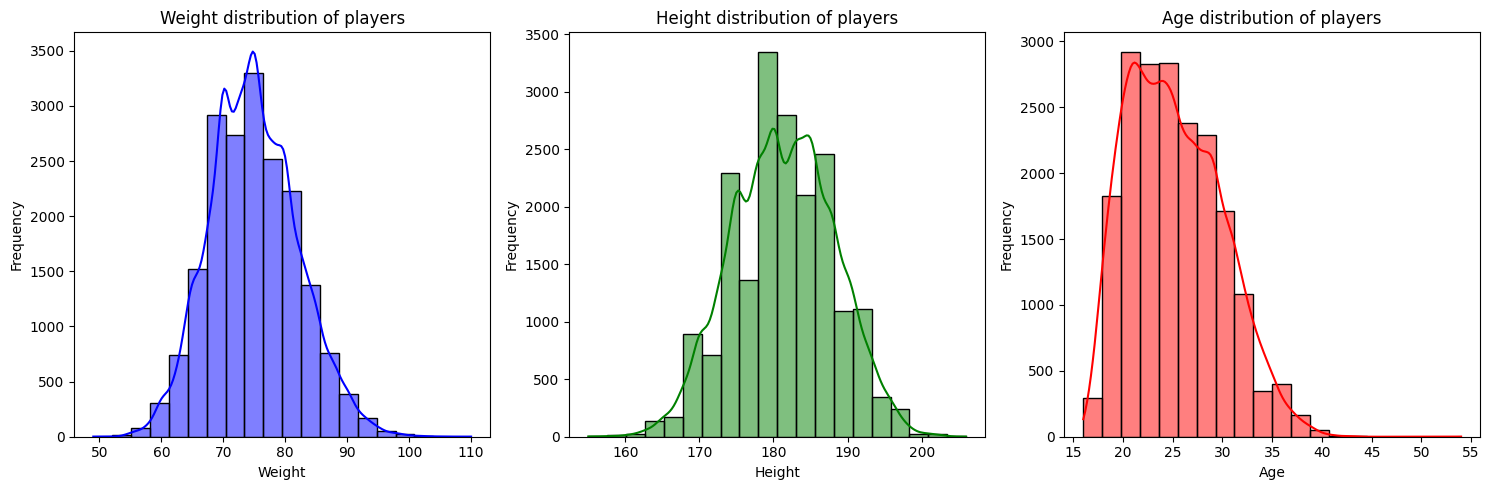

In [323]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(df['Weight'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Weight distribution of players')
axes[0].set_xlabel('Weight')
axes[0].set_ylabel('Frequency')


sns.histplot(df['Height'], bins=20, kde=True, color='green', ax=axes[1])
axes[1].set_title('Height distribution of players')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')


sns.histplot(df['Age'], bins=20, kde=True, color='red', ax=axes[2])
axes[2].set_title('Age distribution of players')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Frequency')

plt.tight_layout()  
plt.show()

Most common nationalities of players

C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\4120109782.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top_10, x='Nationality', order=top_10_nationalities, palette=colors)


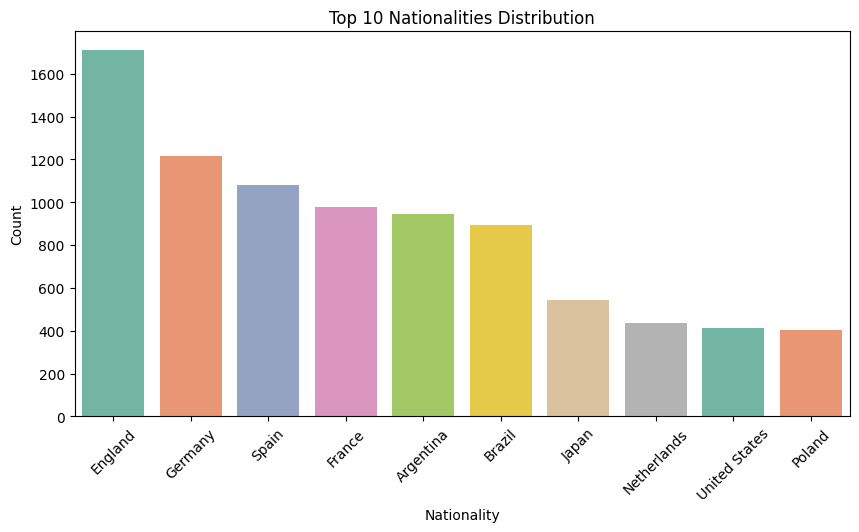

In [324]:
top_10_nationalities = df['Nationality'].value_counts().head(10).index.tolist()


df_top_10 = df[df['Nationality'].isin(top_10_nationalities)]


colors = sns.color_palette('Set2', n_colors=10)


plt.figure(figsize=(10, 5))
sns.countplot(data=df_top_10, x='Nationality', order=top_10_nationalities, palette=colors)
plt.title('Top 10 Nationalities Distribution')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


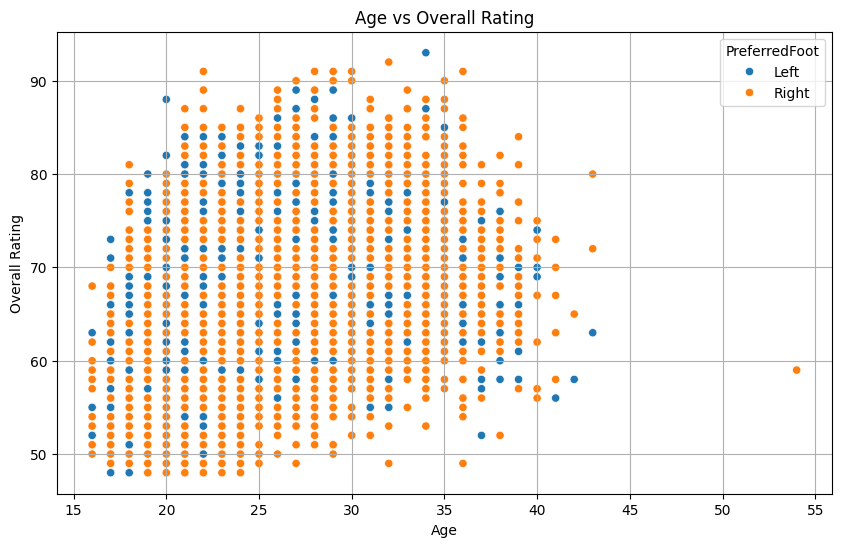

In [325]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Overall', hue='PreferredFoot')
plt.title('Age vs Overall Rating')
plt.xlabel('Age')
plt.ylabel('Overall Rating')
plt.grid(True)
plt.show()

Hypotézy

The distribution of preferred foot among the top performers is the same as the distribution of preferred foot in the entire data set.

In [326]:
# calculate Foot Distribution in the dataset
foot_distribution = df['PreferredFoot'].value_counts(normalize=True) * 100

top_performers_threshold = df['Overall'].quantile(0.90)
top_performers = df[df['Overall'] >= top_performers_threshold]


top_performers_foot_distribution = top_performers['PreferredFoot'].value_counts(normalize=True) * 100


print("Foot Distribution in the dataset:")
print(foot_distribution)
print("\nFoot Distribution among top performers:")
print(top_performers_foot_distribution)


observed_frequencies = top_performers['PreferredFoot'].value_counts()
expected_frequencies = foot_distribution * len(top_performers) / 100


Foot Distribution in the dataset:
PreferredFoot
Right   76.17
Left    23.83
Name: proportion, dtype: float64

Foot Distribution among top performers:
PreferredFoot
Right   74.13
Left    25.87
Name: proportion, dtype: float64


Distribution remained roughly same with minimial deviation, hypotesis confirmed

Is there a relation between overall rating of players and wages? Are better players better paid?

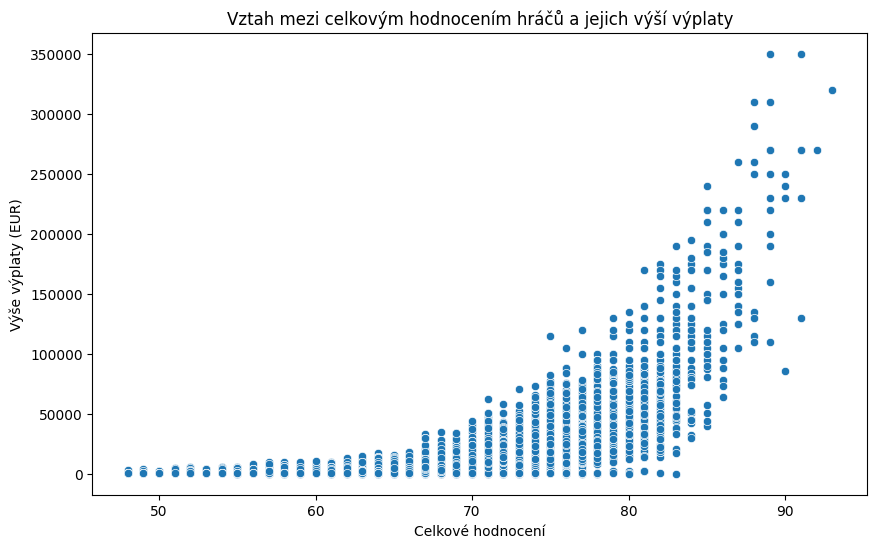

In [327]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Overall', y='WageEUR', data=df)
plt.title('Vztah mezi celkovým hodnocením hráčů a jejich výší výplaty')
plt.xlabel('Celkové hodnocení')
plt.ylabel('Výše výplaty (EUR)')
plt.show()

Wages grow in relation to overall rating, it starts slow at average and above average players and then rapidly grows with the best players. Anomalies are minimal.

Better players are better paid (logically)

In [328]:
top_n = 5
def display_top_performers(column_name):
    top_performers = df.nlargest(top_n, column_name)
    print(f"Nejlepší {top_n} podle {column_name}:")
    print(tabulate(top_performers[['Name', 'Age', column_name]], headers='keys', tablefmt='pretty'))
display_top_performers('Overall')        
display_top_performers('ShootingTotal')   
display_top_performers('ValueEUR')   
display_top_performers('Potential')  
display_top_performers('WageEUR')


Nejlepší 5 podle Overall:
+--------+-------------------+-----+---------+
|   ID   |       Name        | Age | Overall |
+--------+-------------------+-----+---------+
| 158023 |     L. Messi      | 34  |   93    |
| 188545 |  R. Lewandowski   | 32  |   92    |
| 20801  | Cristiano Ronaldo | 36  |   91    |
| 231747 |     K. Mbappé     | 22  |   91    |
| 200389 |     J. Oblak      | 28  |   91    |
+--------+-------------------+-----+---------+
Nejlepší 5 podle ShootingTotal:
+--------+-------------------+-----+---------------+
|   ID   |       Name        | Age | ShootingTotal |
+--------+-------------------+-----+---------------+
| 20801  | Cristiano Ronaldo | 36  |      94       |
| 158023 |     L. Messi      | 34  |      92       |
| 188545 |  R. Lewandowski   | 32  |      92       |
| 200389 |     J. Oblak      | 28  |      92       |
| 202126 |      H. Kane      | 27  |      91       |
+--------+-------------------+-----+---------------+
Nejlepší 5 podle ValueEUR:
+--------+-----

Clustering


In [329]:
df_clustering = df
df_clustering


,Name,Age,Height,Weight,Overall,Potential,WageEUR,ValueEUR,Growth,Nationality,BestPosition,PreferredFoot,ShootingTotal,DefendingTotal,WeakFoot,SkillMoves
ID,,,,,,,,,,,,,,,,
158023,L. Messi,34,170,72,93,93,320000,78000000,0,Argentina,RW,Left,92,34,4,4
188545,R. Lewandowski,32,185,81,92,92,270000,119500000,0,Poland,ST,Right,92,44,4,4
20801,Cristiano Ronaldo,36,187,83,91,91,270000,45000000,0,Portugal,ST,Right,94,34,4,5
231747,K. Mbappé,22,182,73,91,95,230000,194000000,4,France,ST,Right,88,36,4,5
200389,J. Oblak,28,188,87,91,93,130000,112000000,2,Slovenia,GK,Right,92,52,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262759,S. Black,19,180,75,48,62,500,100000,14,Republic of Ireland,CB,Right,27,48,3,2
250978,Ma Zhen,23,196,85,48,52,1000,50000,4,China PR,GK,Right,47,54,2,1
261985,Yang Haoyu,20,183,77,48,55,1000,90000,7,China PR,CB,Right,26,51,3,2


Using getdummies for **PreferredFoot** since it has low amount of unique values 
and Targeted encoding for **Nationality** and **Best position** 

In [330]:
df_clustering.describe(exclude=np.number)

,Name,Nationality,BestPosition,PreferredFoot
count,19156,19156,19156,19156
unique,18058,163,15,2
top,J. Rodríguez,England,CB,Right
freq,12,1712,3725,14591


In [331]:
pd.get_dummies(df_clustering[['PreferredFoot']]).astype(int)

,PreferredFoot_Left,PreferredFoot_Right
ID,,
158023,1,0
188545,0,1
20801,0,1
231747,0,1
200389,0,1
...,...,...
262759,0,1
250978,0,1
261985,0,1


In [332]:

mean_value_by_nationality = df_clustering.groupby('Nationality')['ValueEUR'].mean()
mean_value_by_best_position = df_clustering.groupby('BestPosition')['ValueEUR'].mean()

df_clustering['Nationality_encoded'] = df_clustering['Nationality'].map(mean_value_by_nationality)
df_clustering['BestPosition_encoded'] = df_clustering['BestPosition'].map(mean_value_by_best_position)

df_clustering.drop(columns=['Nationality', 'BestPosition'], inplace=True)

print(df_clustering.columns)

Index(['Name', 'Age', 'Height', 'Weight', 'Overall', 'Potential', 'WageEUR',
       'ValueEUR', 'Growth', 'PreferredFoot', 'ShootingTotal',
       'DefendingTotal', 'WeakFoot', 'SkillMoves', 'Nationality_encoded',
       'BestPosition_encoded'],
      dtype='object')


In [333]:
df_clustering.describe()
df_clustering.columns

Index(['Name', 'Age', 'Height', 'Weight', 'Overall', 'Potential', 'WageEUR',
       'ValueEUR', 'Growth', 'PreferredFoot', 'ShootingTotal',
       'DefendingTotal', 'WeakFoot', 'SkillMoves', 'Nationality_encoded',
       'BestPosition_encoded'],
      dtype='object')

In [334]:
df_clustering.shape

(19156, 16)

In [335]:
df_clustering.describe(include=np.number)

,Age,Height,Weight,Overall,Potential,WageEUR,ValueEUR,Growth,ShootingTotal,DefendingTotal,WeakFoot,SkillMoves,Nationality_encoded,BestPosition_encoded
count,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00,19156.00
mean,25.19,181.30,74.95,65.77,71.05,8894.35,2825776.20,5.29,53.50,50.01,2.95,2.35,2825776.20,2825776.20
std,4.74,6.87,7.07,6.80,6.07,19407.92,7609954.37,5.48,13.81,16.37,0.67,0.77,1603688.04,824741.69
min,16.00,155.00,49.00,48.00,49.00,0.00,0.00,0.00,18.00,14.00,1.00,1.00,130000.00,1926228.88
25%,21.00,176.00,70.00,61.00,67.00,1000.00,475000.00,0.00,44.00,35.00,3.00,2.00,1503056.99,2429059.06
50%,25.00,181.00,75.00,66.00,71.00,3000.00,975000.00,4.00,56.00,54.00,3.00,2.00,2512342.29,2621590.91
75%,29.00,186.00,80.00,70.00,75.00,8000.00,2000000.00,9.00,64.00,63.00,3.00,3.00,4326699.03,2846156.45
max,54.00,206.00,110.00,93.00,95.00,350000.00,194000000.00,26.00,94.00,91.00,5.00,5.00,12538636.36,8314153.83


Now we will work with numeric columns

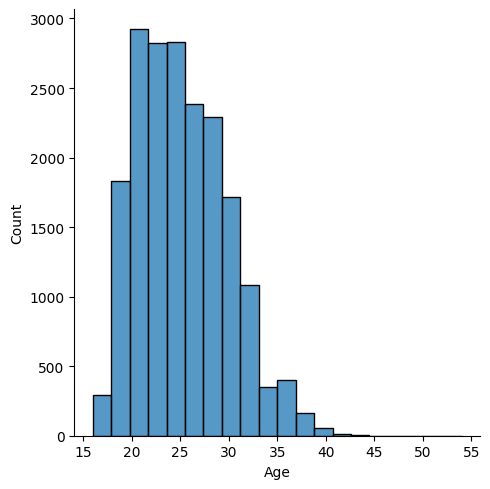

In [336]:
sns.displot(df_clustering.Age, bins=20)

Age seems pretty well balanced and positioned for clustering

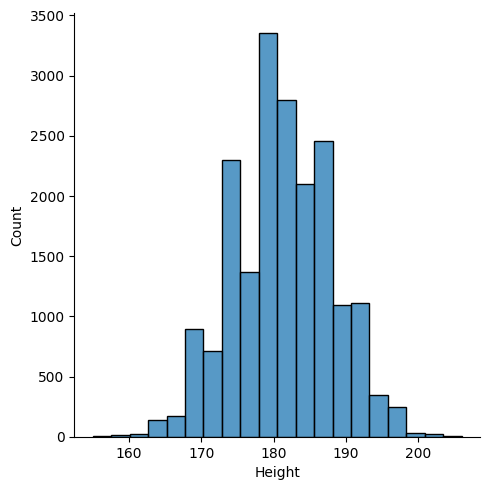

In [337]:
sns.displot(df_clustering.Height, bins=20)

Height seems pretty well balanced and positioned for clustering

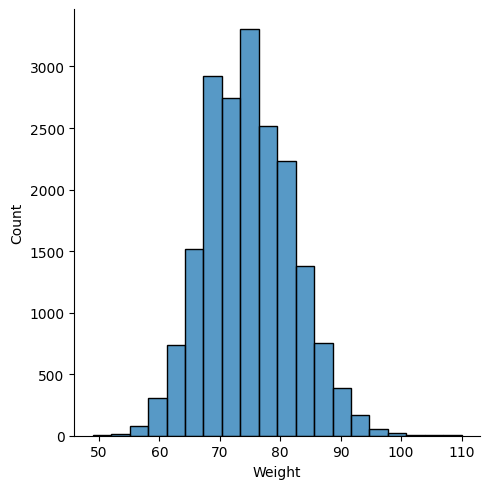

In [338]:
sns.displot(df_clustering.Weight, bins=20)

Height seems pretty well balanced and positioned for clustering

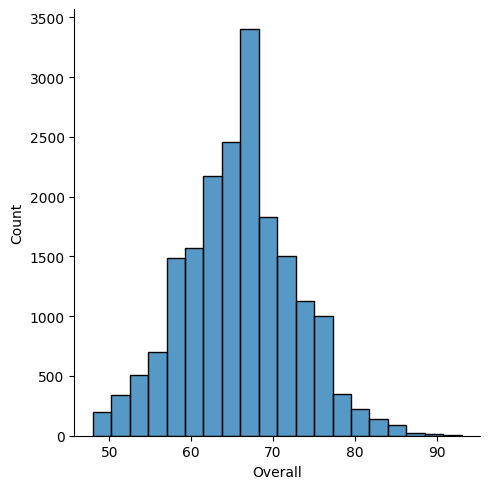

In [339]:
sns.displot(df_clustering.Overall, bins=20)

Overall seems pretty well balanced and positioned for clustering

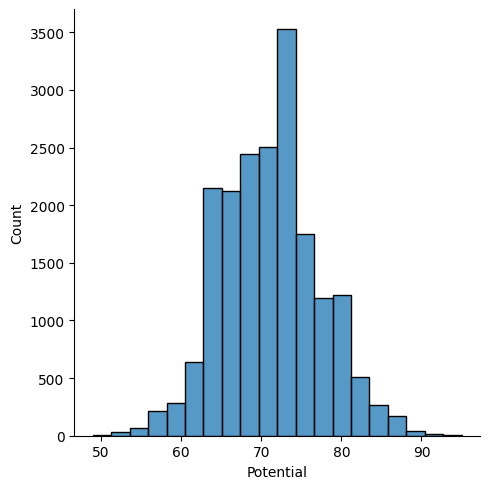

In [340]:
sns.displot(df_clustering.Potential, bins=20)

Overall seems pretty well balanced and positioned for clustering

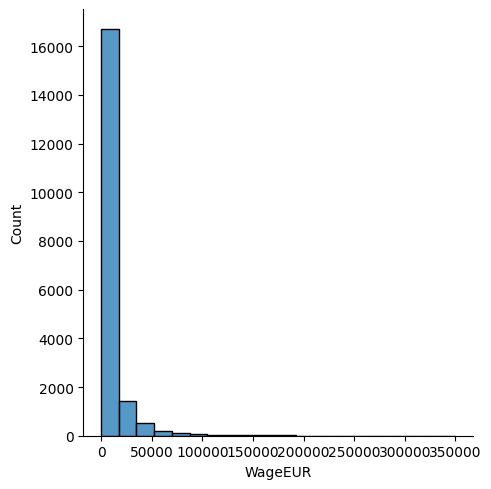

In [341]:
sns.displot(df_clustering.WageEUR, bins=20)

In [342]:
df_clustering.WageEUR.value_counts()

WageEUR
2000      2937
500       2248
1000      2023
3000      1810
4000      1130
          ... 
240000       2
350000       2
195000       1
290000       1
320000       1
Name: count, Length: 134, dtype: int64

Values are leaning too much to one side so I am gonna use PowerTransformer to center them.

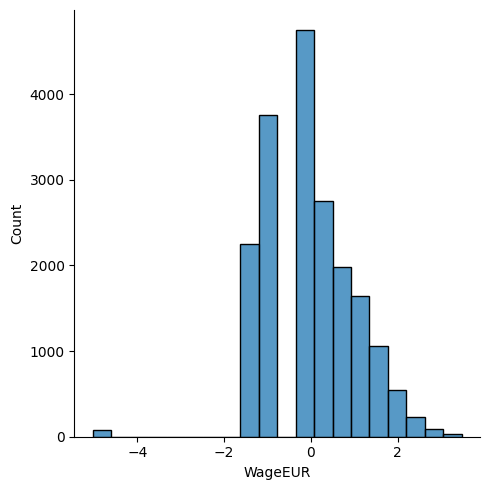

In [343]:
enc_pwr = sklearn.preprocessing.PowerTransformer()


df_clustering['WageEUR'] = enc_pwr.fit_transform(df_clustering[['WageEUR']])


sns.displot(df_clustering['WageEUR'], bins=20)

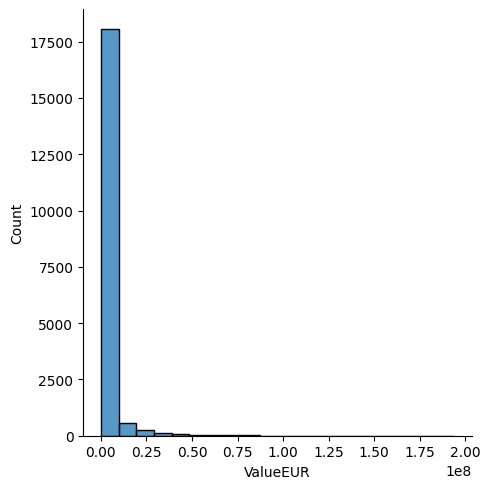

In [344]:
sns.displot(df_clustering.ValueEUR, bins=20)

Same problem as WageEUR

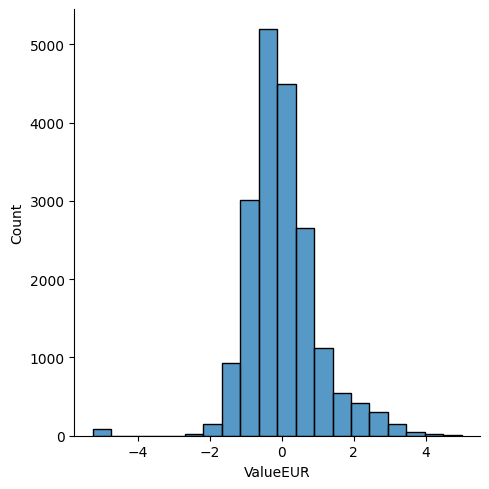

In [345]:
enc_pwr = sklearn.preprocessing.PowerTransformer()
df_clustering['ValueEUR'] = enc_pwr.fit_transform(df_clustering[['ValueEUR']])
sns.displot(df_clustering['ValueEUR'], bins=20)

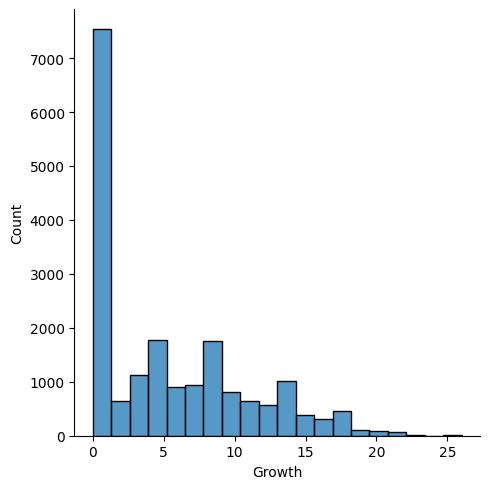

In [346]:
sns.displot(df_clustering['Growth'], bins=20)

Normalizing Growth through minmax scale 

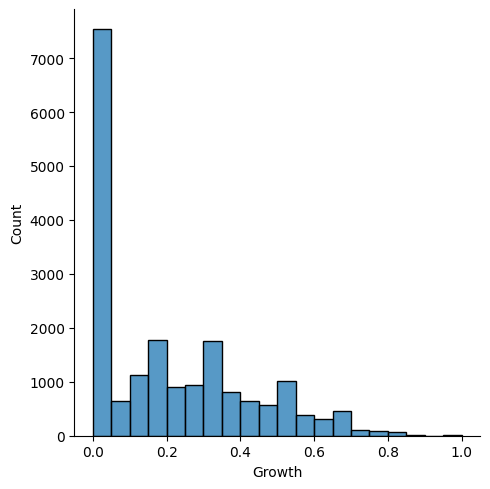

In [347]:
df_clustering['Growth'] = sklearn.preprocessing.minmax_scale(df_clustering.Growth)
sns.displot(df_clustering.Growth, bins=20)

Using PowerTransformer on the rest of the numeric columns to get them into better form

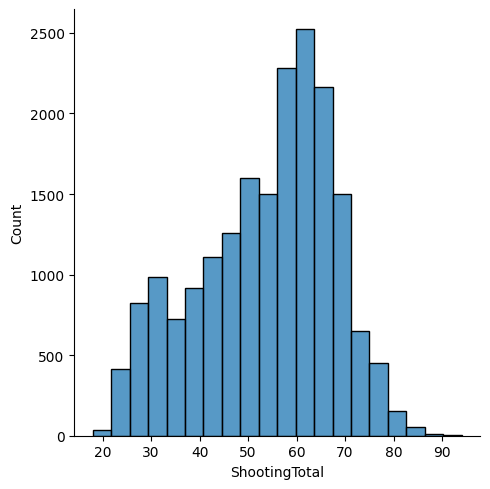

In [348]:
sns.displot(df_clustering.ShootingTotal, bins=20)

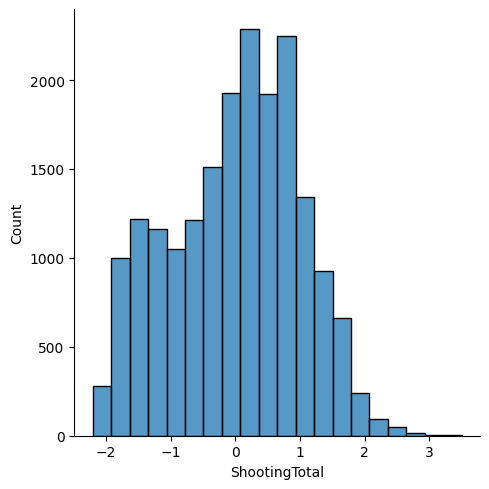

In [349]:
enc_pwr = sklearn.preprocessing.PowerTransformer()
df_clustering['ShootingTotal'] = enc_pwr.fit_transform(df_clustering[['ShootingTotal']])
sns.displot(df_clustering['ShootingTotal'], bins=20)

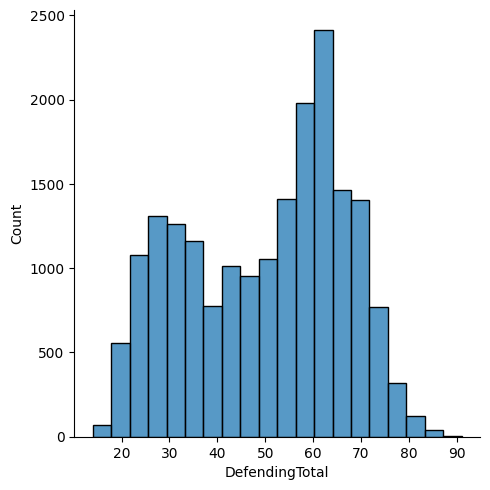

In [350]:
sns.displot(df_clustering.DefendingTotal, bins=20)

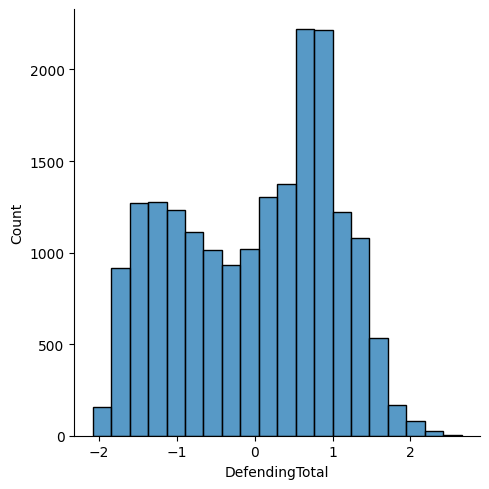

In [351]:
enc_pwr = sklearn.preprocessing.PowerTransformer()
df_clustering['DefendingTotal'] = enc_pwr.fit_transform(df_clustering[['DefendingTotal']])
sns.displot(df_clustering['DefendingTotal'], bins=20)

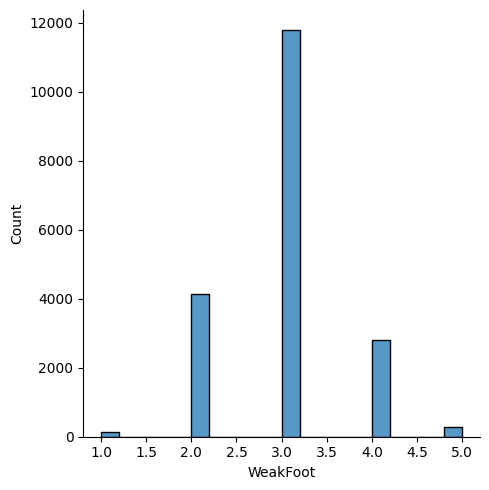

In [352]:
sns.displot(df_clustering.WeakFoot, bins=20)

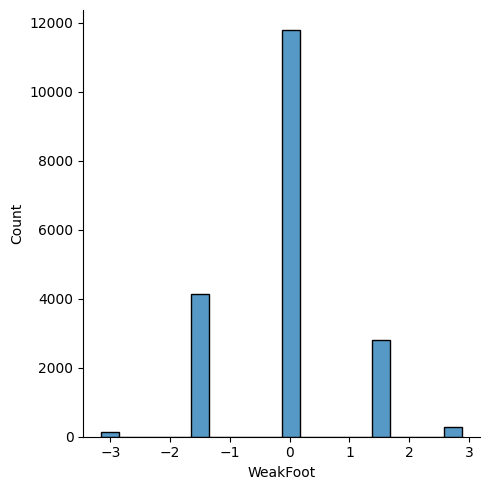

In [353]:
enc_pwr = sklearn.preprocessing.PowerTransformer()
df_clustering['WeakFoot'] = enc_pwr.fit_transform(df_clustering[['WeakFoot']])
sns.displot(df_clustering['WeakFoot'], bins=20)

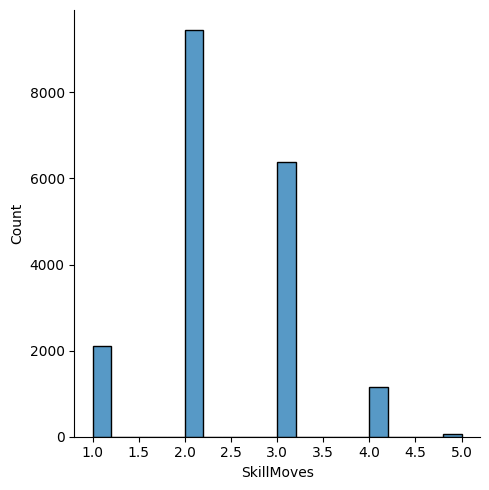

In [354]:
sns.displot(df_clustering['SkillMoves'], bins=20)

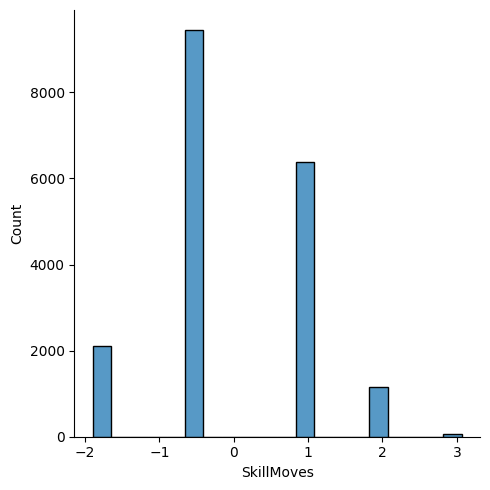

In [355]:
enc_pwr = sklearn.preprocessing.PowerTransformer()
df_clustering['SkillMoves'] = enc_pwr.fit_transform(df_clustering[['SkillMoves']])
sns.displot(df_clustering['SkillMoves'], bins=20)

**Part 1** - Kmeans


In [356]:
df_clustering.drop(columns=['Name'], inplace=True)
df_clustering.drop(columns=['PreferredFoot'], inplace=True)
numeric_df = df_clustering


In [357]:
print(numeric_df.dtypes)

Age                       int64
Height                    int64
Weight                    int64
Overall                   int64
Potential                 int64
WageEUR                 float64
ValueEUR                float64
Growth                  float64
ShootingTotal           float64
DefendingTotal          float64
WeakFoot                float64
SkillMoves              float64
Nationality_encoded     float64
BestPosition_encoded    float64
dtype: object


Finding the optimal number of clusters

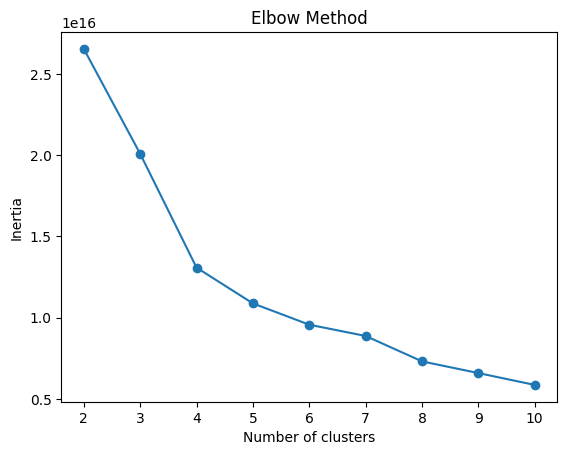

In [358]:
inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=13)
    kmeans.fit(numeric_df)
    inertia.append(kmeans.inertia_)


plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


Edge method suggests that the optimal number of clusters is 3-4. I am going with four since with four clusters they are more balanced.

<Axes: xlabel='cluster_id', ylabel='count'>

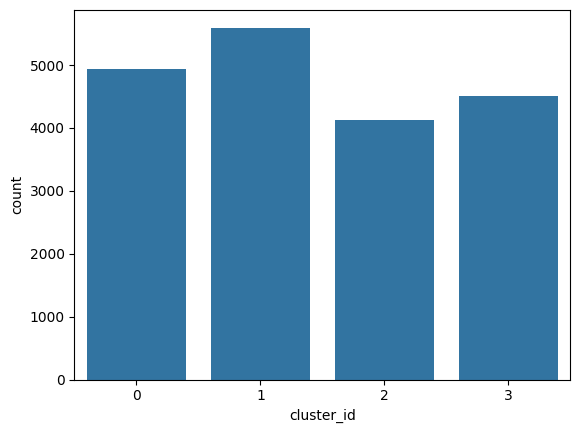

In [359]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

chosen_clusters = 4 

kmeans = KMeans(n_clusters=chosen_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

numeric_df['cluster_id'] = cluster_labels
numeric_df.columns

sns.countplot(data=numeric_df, x='cluster_id')


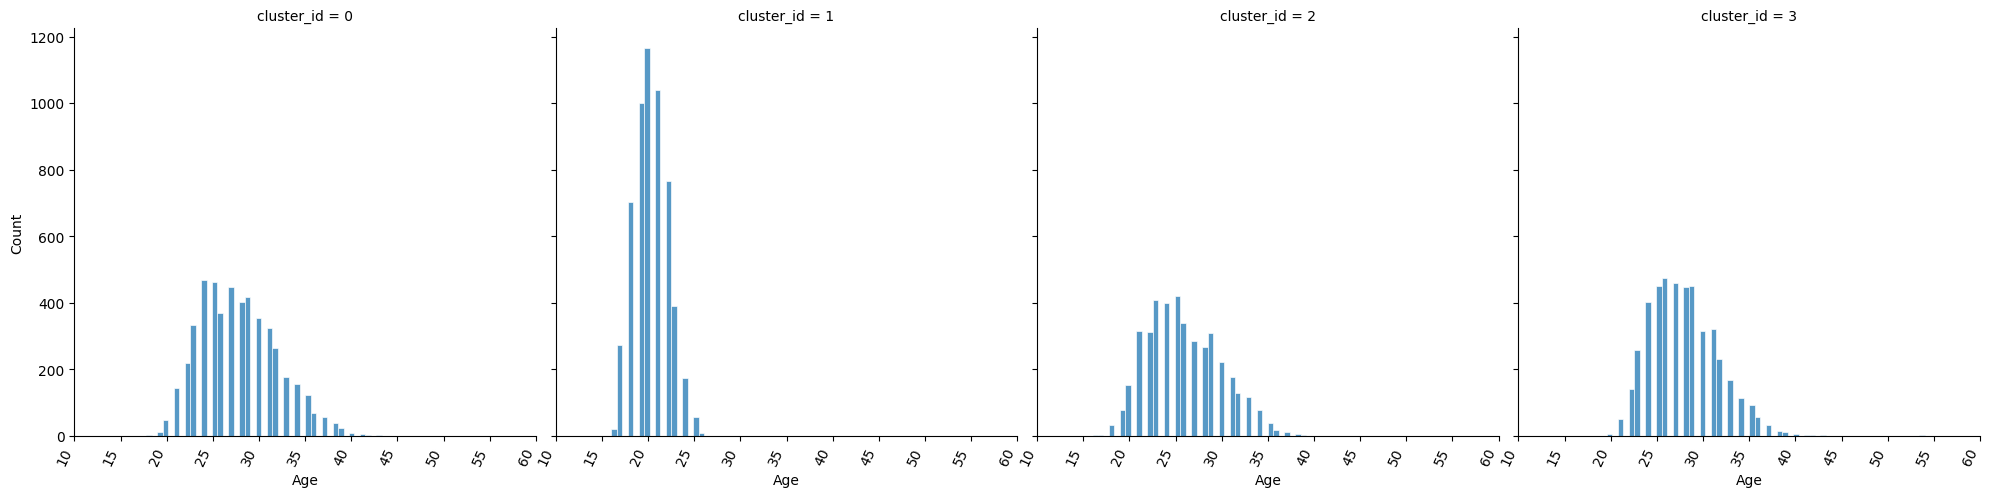

In [360]:
g = sns.displot(data=numeric_df, x='Age', col='cluster_id', edgecolor='white')
g.set_xticklabels(rotation=65, horizontalalignment='right')

In [361]:

average_age_per_cluster = numeric_df.groupby('cluster_id')['Age'].mean()
print("Average Age in Each Cluster:")
print(average_age_per_cluster)

Average Age in Each Cluster:
cluster_id
0   27.77
1   20.26
2   25.88
3   27.86
Name: Age, dtype: float64


In [362]:

median_age_per_cluster = numeric_df.groupby('cluster_id')['Age'].median()
print("Median Age in Each Cluster:")
print(median_age_per_cluster)

Median Age in Each Cluster:
cluster_id
0   27.00
1   20.00
2   25.00
3   28.00
Name: Age, dtype: float64


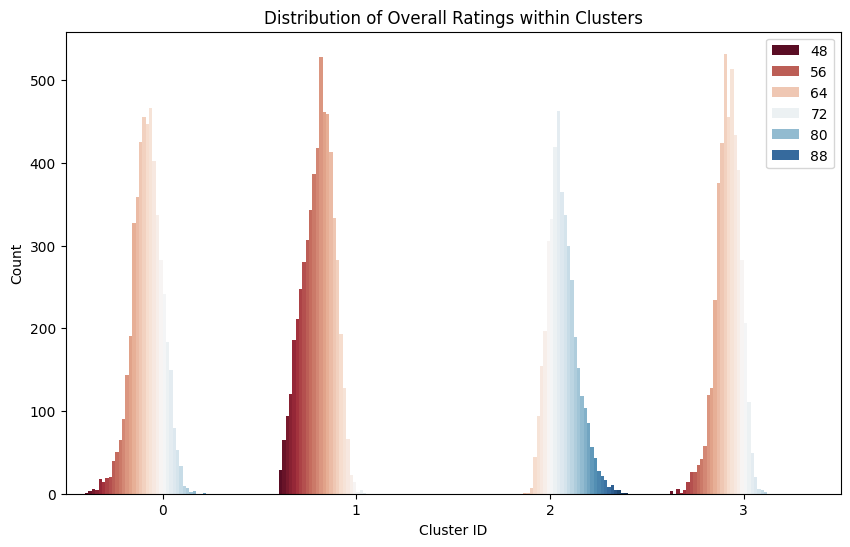

In [363]:

plt.figure(figsize=(10, 6))
sns.countplot(data=numeric_df, x='cluster_id', hue='Overall', palette='RdBu')
plt.title('Distribution of Overall Ratings within Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

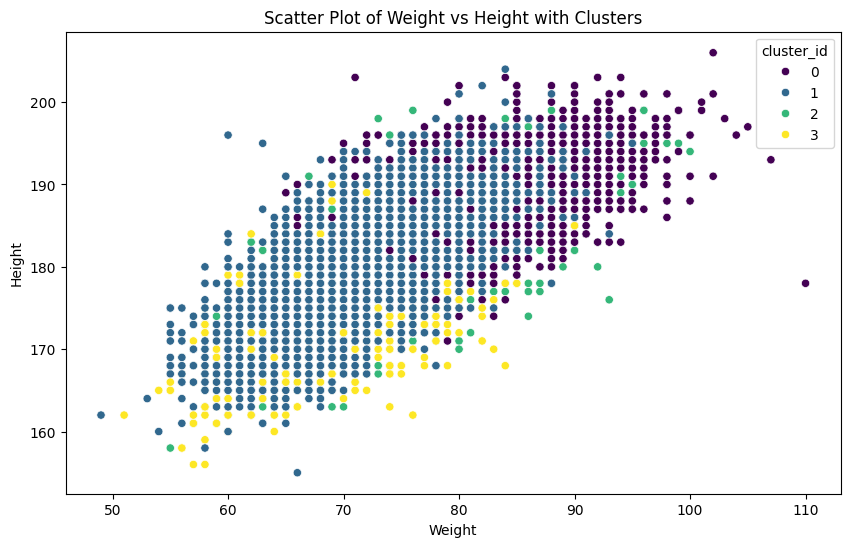

In [364]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=numeric_df, x='Weight', y='Height', hue='cluster_id', palette='viridis')
plt.title('Scatter Plot of Weight vs Height with Clusters')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()


In [365]:
print(numeric_df.columns)


Index(['Age', 'Height', 'Weight', 'Overall', 'Potential', 'WageEUR',
       'ValueEUR', 'Growth', 'ShootingTotal', 'DefendingTotal', 'WeakFoot',
       'SkillMoves', 'Nationality_encoded', 'BestPosition_encoded',
       'cluster_id'],
      dtype='object')


C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2396041919.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='WageEUR', ci=None, palette='viridis')
C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2396041919.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='WageEUR', ci=None, palette='viridis')


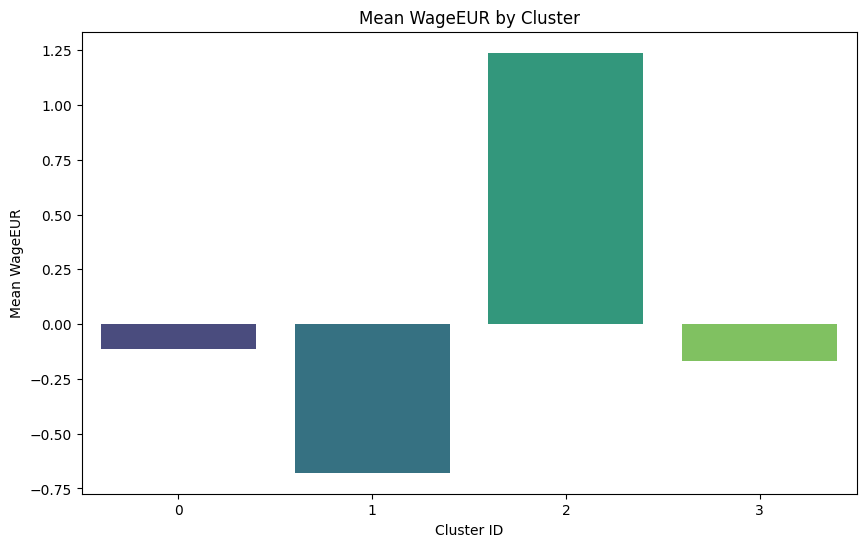

In [366]:
plt.figure(figsize=(10, 6))
sns.barplot(data=numeric_df, x='cluster_id', y='WageEUR', ci=None, palette='viridis')
plt.title('Mean WageEUR by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean WageEUR')
plt.show()


C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2374456108.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='Potential', ci=None, palette='viridis')
C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2374456108.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='Potential', ci=None, palette='viridis')


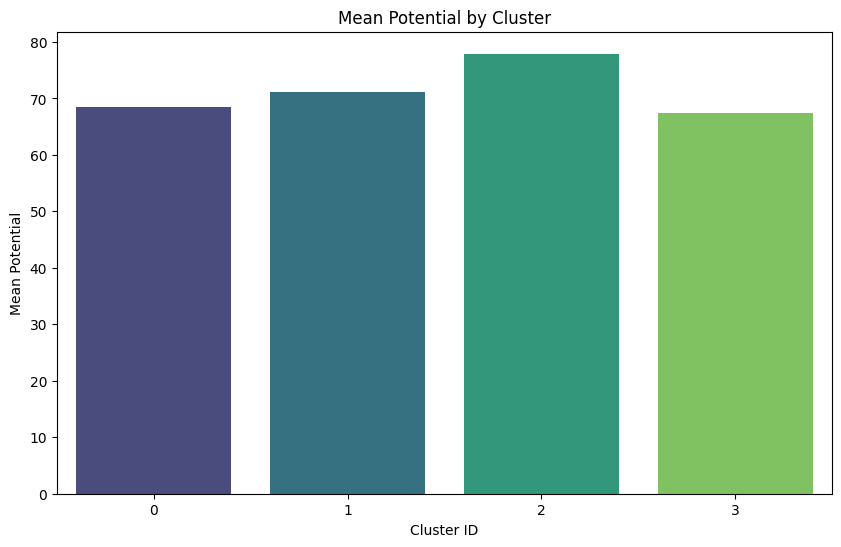

In [367]:
plt.figure(figsize=(10, 6))
sns.barplot(data=numeric_df, x='cluster_id', y='Potential', ci=None, palette='viridis')
plt.title('Mean Potential by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Potential')
plt.show()


C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\805967095.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='Overall', ci=None, palette='viridis')
C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\805967095.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='Overall', ci=None, palette='viridis')


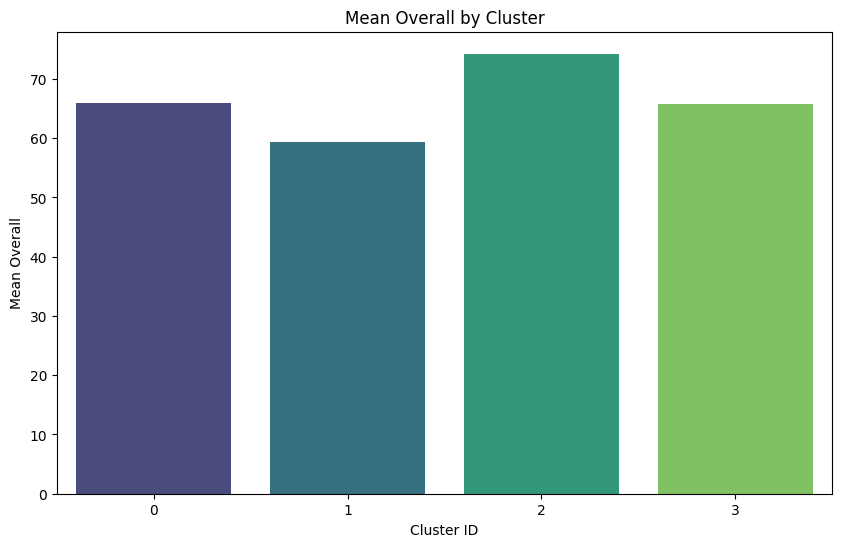

In [368]:
plt.figure(figsize=(10, 6))
sns.barplot(data=numeric_df, x='cluster_id', y='Overall', ci=None, palette='viridis')
plt.title('Mean Overall by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean Overall')
plt.show()

C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2006913431.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='ValueEUR', ci=None, palette='viridis')
C:\Users\Petr\AppData\Local\Temp\ipykernel_6744\2006913431.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=numeric_df, x='cluster_id', y='ValueEUR', ci=None, palette='viridis')


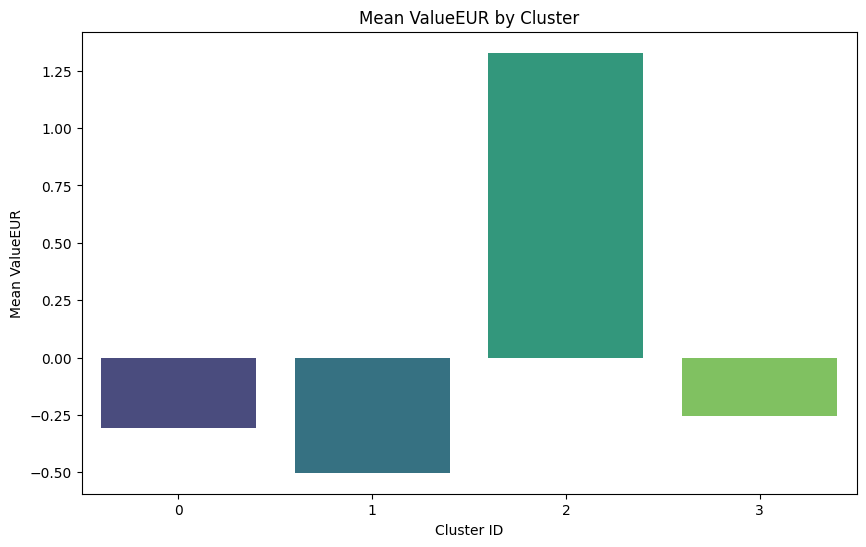

In [369]:
plt.figure(figsize=(10, 6))
sns.barplot(data=numeric_df, x='cluster_id', y='ValueEUR', ci=None, palette='viridis')
plt.title('Mean ValueEUR by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Mean ValueEUR')
plt.show()

##### Cluster 0
- On average has the heaviest players in terms of weight vs height
- Least valued players
- Average in most metrics

##### Cluster 1
- Largest cluster
- Most balanced in terms of weight vs height
- Players with worst wages on average
- Players with worst value on average
- Worst players overall on average
- Players with worst ratings
- Youngest players

##### Cluster 2
- Has most best overall players
- Smallest cluster
- Most chaotic distribution of players in terms of weight vs height¨
- Best paid players on average
- Best players on average
- Players have the most potential on average
- Best rated players

##### Cluster 3
- Least potential from all the clusters
- Oldest players from all the clusters
- Average in most metrics

Part 2

Choosing a smaller dataset randomly so the computations are faster

In [370]:
print(numeric_df.shape)
num_rows = len(numeric_df)


num_rows_to_select = num_rows // 15

smaller_df = numeric_df.sample(n=num_rows_to_select, random_state=42)
print(smaller_df.shape)

(19156, 15)
(1277, 15)


Method for dendogram plotting:

In [371]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Credit to https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)


    plt.title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel('distance')

Usage Agglomerative Clustering:

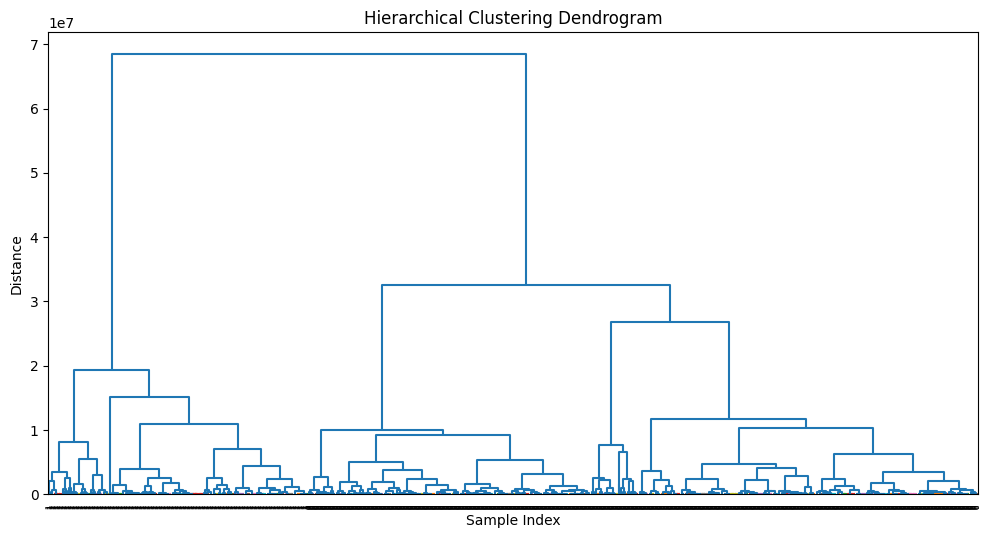

In [372]:
axline = 4e7
agglom = AgglomerativeClustering(distance_threshold=axline, n_clusters=None)
agglom.fit(smaller_df)

plt.figure(figsize=(12, 6))
plot_dendrogram(agglom, labels=agglom.labels_,color_threshold=999)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

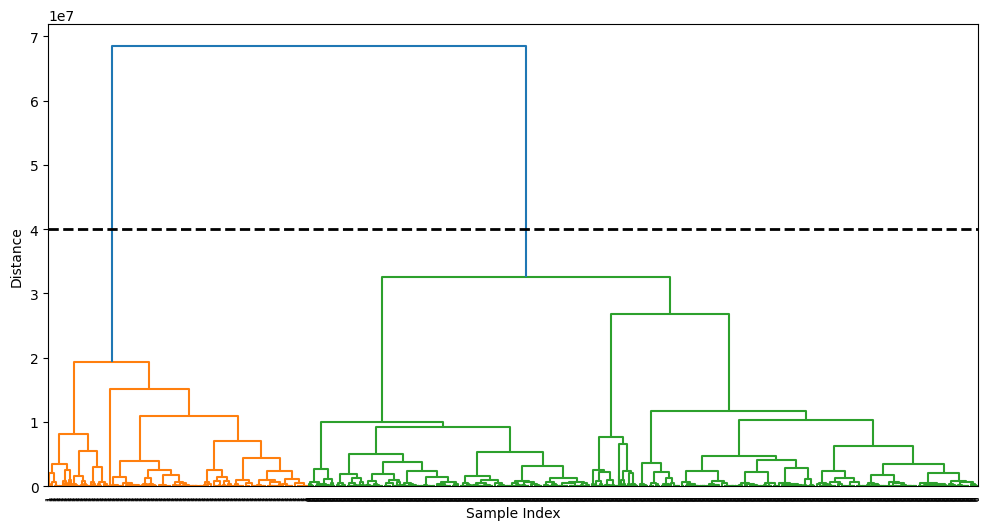

Number of clusters formed: 2


In [392]:
axline = 4e7
clustering = AgglomerativeClustering(linkage='complete', distance_threshold=axline, n_clusters=None)
agglom.fit(smaller_df)

linkage_matrix = linkage(smaller_df, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=agglom.labels_, color_threshold=axline)

plt.axhline(y=axline, color='black', linestyle='--', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()
num_clusters = agglom.n_clusters_

print(f"Number of clusters formed: {num_clusters}")

<Axes: ylabel='count'>

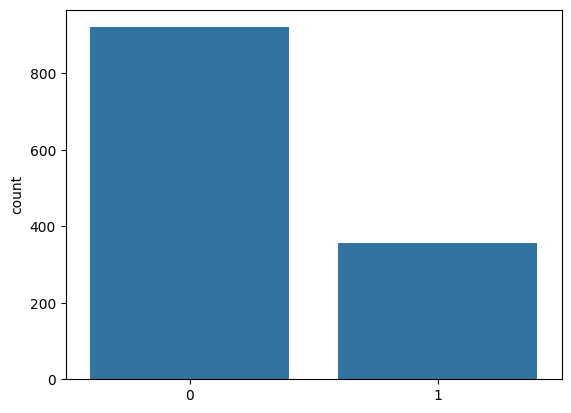

In [394]:
sns.countplot(data=smaller_df, x=agglom.labels_)

In [395]:
smaller_df.columns

Index(['Age', 'Height', 'Weight', 'Overall', 'Potential', 'WageEUR',
       'ValueEUR', 'Growth', 'ShootingTotal', 'DefendingTotal', 'WeakFoot',
       'SkillMoves', 'Nationality_encoded', 'BestPosition_encoded',
       'cluster_id'],
      dtype='object')

<Axes: ylabel='ShootingTotal'>

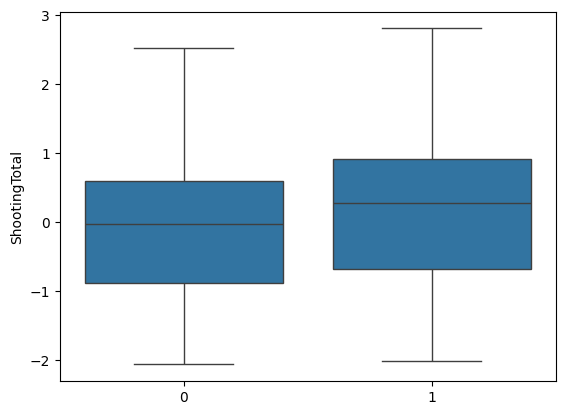

In [434]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='ShootingTotal')

<Axes: ylabel='count'>

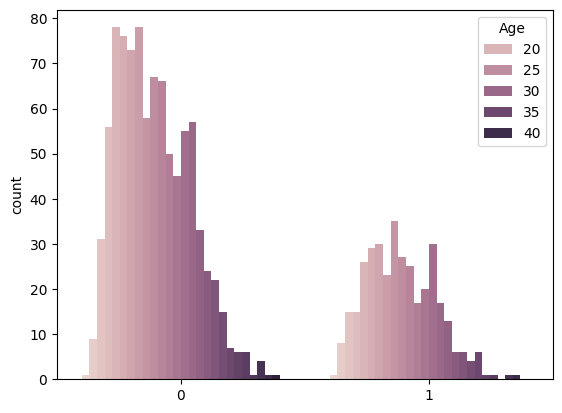

In [396]:
sns.countplot(data=smaller_df, x=agglom.labels_, hue='Age')

<Axes: ylabel='Height'>

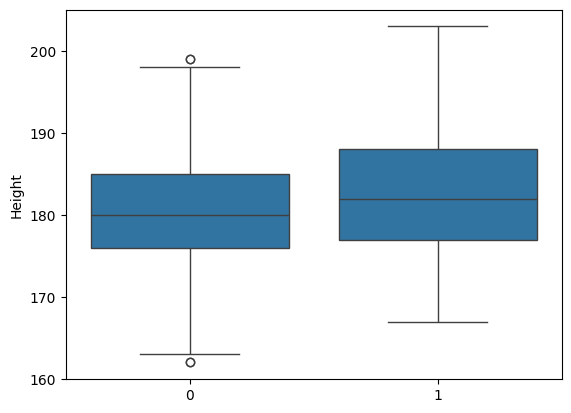

In [430]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='Height')

In [ ]:
sns.countplot(data=smaller_df, x=agglom.labels_, hue='Height')

<Axes: ylabel='Overall'>

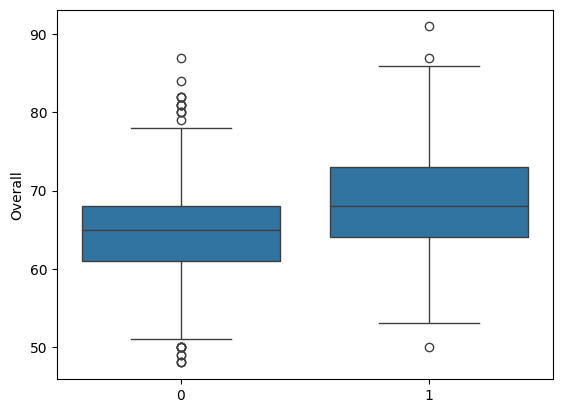

In [404]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='Overall')

<Axes: ylabel='WageEUR'>

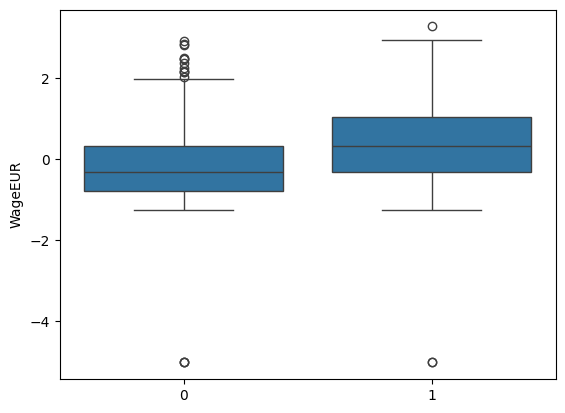

In [423]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='WageEUR')

<Axes: ylabel='ValueEUR'>

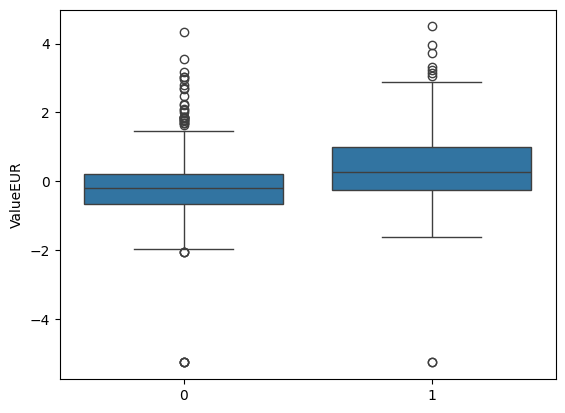

In [424]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='ValueEUR')

<Axes: ylabel='Potential'>

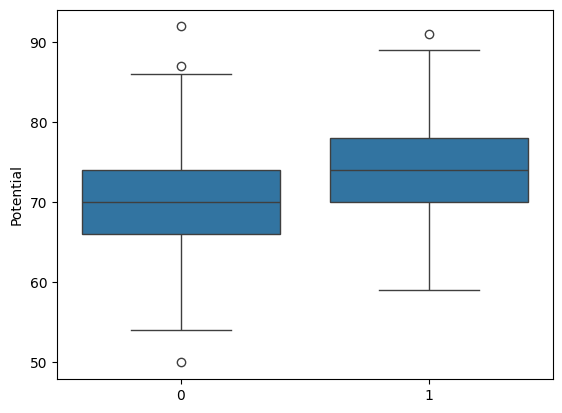

In [436]:
sns.boxplot(data=smaller_df, x=agglom.labels_, y='Potential')


**Cluster 0**
- Larger sample size
- Worse in every measured metric (Older and shorter players, worse valued and paid with less potential)

**Cluster 1**
- Smaller sample size
- Better in every measured metric (Younger and taller players, better valued and paid with more potential)

#### Summary:
- The clustering process revealed interesting patterns and correlations within the dataset that were not initially apparent.
- I am not certain whenever all the operations I took in preprocessing pipeline were stricly necessary, but when I done the clustering without preprocessing my data as much, the clusters were much less well balanced so in the least the operations improved the results
- Kmeans clusters were pretty evenly distributed, which allowed me to draw some different insights. They were also better balanced than *AgglomerativeClustering* (at least in my testing):